# CLIP Pipeline

## Preparation

In [1]:
import sys, os
import reload_recursive

# sys path hack to allow importing the encoding functions and other modules
sys.path.insert(0, os.path.abspath('../src'))
sys.path.insert(0, os.path.abspath('../externals'))

In [2]:
import torch 

if torch.cuda.is_available():
    gpu = torch.device("cuda")
elif torch.backends.mps.is_available():
    gpu = torch.device("mps")
else:
    print("Warning: no GPU detected, falling back to CPU")
    gpu = torch.device("cpu")

In [4]:
# Clean old model from cache
if 'model' in locals() or 'model' in globals():
    del model
torch.cuda.empty_cache()

from model.clip_model import CLIPModel
model = CLIPModel(gpu)

# from model.xvlm_itr_coco_model import XVLMModel
# model = XVLMModel(gpu)

# from model.vipergpt_xvlm_model import XVLMModel
# model = XVLMModel(gpu)

2023-05-07 13:15:25.140876: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-07 13:15:25.163276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 13:15:25.609851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reference Question

What is the pan on? -> oven
select: pan (633147)->relate: _,on,o (633148) [0]->query: name [1]


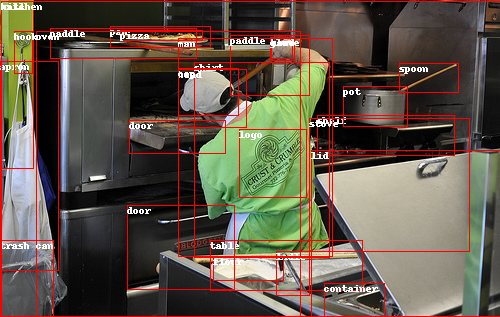

In [5]:
from PIL import Image, ImageDraw
import json

with open("../data/questions/train_sampled_questions_2000.json") as f:
   questions = list(json.load(f).items())

qid, question = questions[3]
print(f"{question['question']} -> {question['answer']}")
print(question['semanticStr'])
image = Image.open(f"../data/images/{question['imageId']}.jpg")

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object in question['sceneGraph']['objects'].values():
   object_crop = image.crop((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']))
   draw.rectangle((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']), outline="red", width=1)
   draw.text((object['x'], object['y']), object["name"], fill="white")

imgcopy

## Concept Extraction

In [6]:
%reload pipeline.concept_extraction
from pipeline.concept_extraction import extract_attributes, extract_classes, extract_relations

print(question['semanticStr'])
print(extract_attributes(question))
print(extract_classes(question))
print(extract_relations(question))

ImportError: cannot import name 'extract_classes' from partially initialized module 'pipeline.concept_extraction' (most likely due to a circular import) (/home/guests/jhadl/git/tuw-master-thesis/src/pipeline/concept_extraction.py)

## Bounding Box Optimization

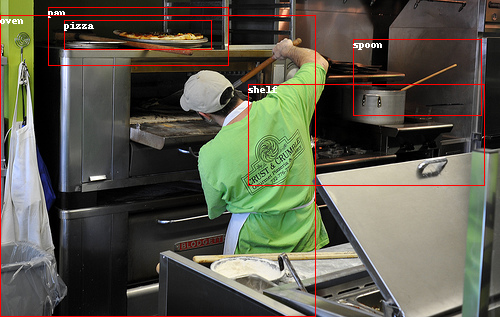

In [ ]:
%reload pipeline.bounding_box_optimization
from pipeline.bounding_box_optimization import get_object_bboxes

objects = list(question['sceneGraph']['objects'].values())
object_bboxes = get_object_bboxes(question)

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for i, object in enumerate(objects[:5]):
    bbox = object_bboxes[i]

    draw.rectangle((bbox[1], bbox[0], bbox[3], bbox[2]), outline="red", width=1)
    draw.text((bbox[1], bbox[0]), f"{object['name']}", fill="white")

imgcopy

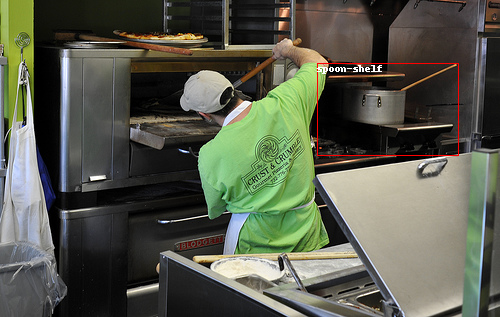

In [ ]:
%reload pipeline.bounding_box_optimization
from pipeline.bounding_box_optimization import get_pair_bboxes

object_pairs = [(2,4)]
pair_bboxes, pair_bbox_indices = get_pair_bboxes(question)

imgcopy = image.copy()
draw = ImageDraw.Draw(imgcopy)

for object_pair in object_pairs:
    bbox = pair_bboxes[pair_bbox_indices[object_pair[0], object_pair[1]]]

    draw.rectangle((bbox[1], bbox[0], bbox[3], bbox[2]), outline="red", width=1)
    draw.text((bbox[1], bbox[0]), f"{objects[object_pair[0]]['name']}-{objects[object_pair[1]]['name']}", fill="white")

imgcopy

## Testing

In [7]:
from clingo.control import Control 
from itertools import islice
%reload pipeline.encoding
from pipeline.encoding import encode_question, encode_scene, sanitize_asp

with open('../src/pipeline/encoding/theory.lp') as theory_file:
    theory = theory_file.read()

num_questions = 10
correct = 0
incorrect = 0

def answer_is_correct(answers, correct_answer):
    correct = False 

    for answer in answers:
        if answer == sanitize_asp(correct_answer): 
            correct = True
        elif (answer == 'to_the_right_of' and correct_answer == 'right') or \
            (answer == 'to_the_left_of' and correct_answer == 'left') or \
            (answer == 'in_front_of' and correct_answer == 'front'):
            correct = True
    return correct 

def count_operators(operator_counts, question):
    for op in question["semantic"]:
        operator = op["operation"].split(" ")[0]
        if operator in operator_counts:
            operator_counts[operator] += 1
        else: 
            operator_counts[operator] = 1

wrong_operator_counts = {}
correct_operator_counts = {}

for qid, question in islice(questions, 0, num_questions):
    
    print(f"Attempting to solve question {qid}")
    print(f"\tQuestion: {question['question']}")
    print(f"\tSemantic: {question['semanticStr']}")
    if question['semantic'][0]['operation'] == 'select' and question['semantic'][0]['argument'] == 'scene':
        num_questions = num_questions - 1
        print("\tQuestion contains 'scene', skipping ...")
        continue

    ctl = Control()
    # ctl.configuration.solver.opt_strategy = "usc,3"
    ctl.add(theory)

    scene_encoding = encode_scene(question, model)
    question_encoding = encode_question(question)

    with open(f"../data/encoded_questions/{qid}.lp", "w") as f:
        f.write("% ------ scene encoding ------\n")
        f.write(scene_encoding)
        f.write("\n% ------ question encoding ------\n")
        f.write(question_encoding)

    ctl.add(scene_encoding)
    ctl.add(question_encoding)

    answers = [[]]
    def on_model(model):
        answers[0] = [s.arguments[0].name for s in model.symbols(shown=True)]

    ctl.ground()
    handle = ctl.solve(on_model=on_model, async_ = True)
    has_finished = handle.wait(timeout=10.0)
    
    if not has_finished:
        print("\tSearch was timed out after 10 seconds!")
    
    if len(answers[0]) > 0:
        if(answer_is_correct(answers[0], question['answer'])):
            print(f"\tResult: correct answer - {answers[0][0]}")
            count_operators(correct_operator_counts, question)
            correct = correct + 1
        else: 
            print(f"\tResult: incorrect answer - {answers[0][0]} (correct: {question['answer']})")
            count_operators(wrong_operator_counts, question)
            incorrect = incorrect + 1
    else: 
        print(f"\tResult: UNSAT")
        count_operators(wrong_operator_counts, question)
        incorrect = incorrect + 1

print("===============================")
print(f"Total questions: {num_questions}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Percentage: {correct/num_questions*100:.3f}%")

print("-------------------------------")
print("Operator failure rate:")
print(wrong_operator_counts)
print(correct_operator_counts)
operator_failure_rates = {}
for operator in {*wrong_operator_counts.keys(), *correct_operator_counts.keys()}:
    if operator in correct_operator_counts and operator in wrong_operator_counts:
        operator_failure_rates[operator] = wrong_operator_counts[operator]/(wrong_operator_counts[operator]+correct_operator_counts[operator])
    elif operator in wrong_operator_counts: 
        operator_failure_rates[operator] = 1
    else:
        operator_failure_rates[operator] = 0

for operator, failure_rate in sorted(operator_failure_rates.items(), key=lambda item: item[1], reverse=True):
    print(f"{operator}: {failure_rate*100:.3f}%")

Attempting to solve question 07787914
	Question: Do you see a door that is not red?
	Semantic: select: door (2102911)->filter color: not(red) [0]->exist: ? [1]
	Result: incorrect answer - yes (correct: no)
Attempting to solve question 19560907
	Question: Who is wearing a shirt?
	Semantic: select: shirt (1282189)->relate: person,wearing,s (1282164) [0]->query: name [1]
	Result: incorrect answer - tie (correct: man)
Attempting to solve question 07328145
	Question: What is the watercraft to the left of the cabin?
	Semantic: select: cabin (800346)->relate: watercraft,to the left of,s (800339) [0]->query: name [1]
	Result: incorrect answer - cabin (correct: boats)
Attempting to solve question 17680743
	Question: What is the pan on?
	Semantic: select: pan (633147)->relate: _,on,o (633148) [0]->query: name [1]
	Result: incorrect answer - apron (correct: oven)
Attempting to solve question 09455791
	Question: What is on the sofa?
	Semantic: select: sofa (672224)->relate: _,on,s (672232) [0]->qu